<a href="https://colab.research.google.com/github/ethantien10/Stock-Prediction-Project/blob/main/STA141C_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("randomForest")
install.packages("dplyr")
# install.packages("glmnet")
# install.packages("caret")
install.packages("corrplot")
install.packages("readr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(dplyr)
library(randomForest)

# prompt: read the dow_jones_index.data file into a data frame
earnings_release <- read.csv('UPDATEDearningsReleaseDates.csv', header = TRUE, sep = ',') # read release date data
earnings_release <- data.frame(earnings_release)    # turn data into data.frame
dow_jones_index <- read.csv('dow_jones_index.data', header = TRUE, sep = ',') # read dow jones data
dow_jones_index <- data.frame(dow_jones_index)    # turn data into data.frame
unUsedTickers <- read.csv('discarded_Tickers.csv', header = TRUE, sep = ',') # read unused tickers
unUsedTickers <- data.frame(unUsedTickers)    # turn data into data.frame
balanceSheet <- read.csv('BALANCE.csv', header = TRUE, sep = ',') # read data
balanceSheet <- data.frame(balanceSheet)    # turn data into data.frame
incomeStatement <- read.csv('INCOME.csv', header = TRUE, sep = ',') # read data
incomeStatement <- data.frame(incomeStatement)    # turn data into data.frame
cashFlowStatement <- read.csv('CASH_FLOW.csv', header = TRUE, sep = ',') # read data
cashFlowStatement <- data.frame(cashFlowStatement)    # turn data into data.frame
calculations <- read.csv('CALCULATIONS.csv', header = TRUE, sep = ',') # read data
calculations <- data.frame(calculations)    # turn data into data.frame


# Create a new row to append
new_row <- data.frame(ticker = "KRFT")

# Append the new row to the unUsedTickers dataframe
unUsedTickers <- rbind(unUsedTickers, new_row)

In [ ]:

# Removing rows from dow_jones_index where the ticker is in unUsedTickers
dow_jones_index_filtered <- dow_jones_index[!dow_jones_index$stock %in% unUsedTickers$ticker, ]


In [ ]:

split_dow_jones_index <- split(dow_jones_index_filtered, f = dow_jones_index_filtered$quarter)
# Further splitting each subgroup by the 'ticker' column
split_by_quarter_and_ticker <- lapply(split_dow_jones_index, function(sub_df) {
  split(sub_df, f = sub_df$stock)
})

# referance quarter using first index
#                            VVVVV
# split_by_quarter_and_ticker[[1]][[2]]
#                                 ^^^^^
# referance company using second index

In [ ]:
# print(earnings_release)
split_earnings_release <- split(earnings_release, f = earnings_release$ticker)
# print(class(split_earnings_release[1]))


# Function to select elements "A", "B", "C"
selectQ1 <- function(x) x[c("ticker", "Q1.release.date", "Q1.week..start.day..compare..this.week.")]

# Function to select elements "A", "B", "D"
selectQ2 <- function(x) x[c("ticker", "Q2.release.date", "Q2.week..start.day..compare..this.week.")]

In [ ]:
# Apply the functions to the original list to create the splits
listQ1 <- lapply(split_earnings_release, selectQ1)
listQ2 <- lapply(split_earnings_release, selectQ2)

In [ ]:

# Function to rename an element within a list, with parameters for old and new names
renameElement <- function(x, oldName, newName) {
  if(oldName %in% names(x)) {
    names(x)[names(x) == oldName] <- newName
  }
  return(x)
}

# Apply the function to each list in listABC, specifying old and new names
# For example, renaming "C" to "NewName"
listQ1_renamed <- lapply(listQ1, renameElement, oldName = "Q1.week..start.day..compare..this.week.", newName = "date")
listQ2_renamed <- lapply(listQ2, renameElement, oldName = "Q2.week..start.day..compare..this.week.", newName = "date")

listQ1_renamed <- lapply(listQ1_renamed, renameElement, oldName = "Q1.release.date", newName = "release_date")
listQ2_renamed <- lapply(listQ2_renamed, renameElement, oldName = "Q2.release.date", newName = "release_date")

listQ1_renamed <- lapply(listQ1_renamed, renameElement, oldName = "ticker", newName = "stock")
listQ2_renamed <- lapply(listQ2_renamed, renameElement, oldName = "ticker", newName = "stock")

In [ ]:

# Convert each inner list to a dataframe
Q1_list_of_dfs <- lapply(listQ1_renamed, function(x) as.data.frame(t(unlist(x)), stringsAsFactors = FALSE))

# Convert each inner list to a dataframe
Q2_list_of_dfs <- lapply(listQ2_renamed, function(x) as.data.frame(t(unlist(x)), stringsAsFactors = FALSE))


In [ ]:
# Combine all dataframes into one
combined_Q1df <- do.call(rbind, Q1_list_of_dfs)
# Combine all dataframes into one
combined_Q2df <- do.call(rbind, Q2_list_of_dfs)


In [ ]:
merged_listQ1_renamed <- merge(dow_jones_index, combined_Q1df, by = c("stock", "date"))


merged_listQ2_renamed <- merge(dow_jones_index, combined_Q2df, by = c("stock", "date"))

In [ ]:

combined_earnings_df <- rbind(merged_listQ1_renamed, merged_listQ2_renamed)


In [ ]:
# Use anti_join to find unmerged rows from df1
unmerged_DJI <- anti_join(dow_jones_index_filtered, combined_earnings_df, by = c("stock", "date"))

In [ ]:
# Perform Welch's t-test to find if there is a statistically significant difference between the volume of earnings weeks and non-earnings weeks.
t_test_result <- t.test(combined_earnings_df$volume, unmerged_DJI$volume, var.equal = FALSE)
print(t_test_result)



	Welch Two Sample t-test

data:  combined_earnings_df$volume and unmerged_DJI$volume
t = -0.27549, df = 51.146, p-value = 0.7841
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -40761971  30924204
sample estimates:
mean of x mean of y 
103568741 108487625 



The p-value is 0.7841. Since this is extremely high, we fail to reject the null hypothesis that there is a statistically significant difference in volumes between earning weeks and non-earning weeks.

In [ ]:
# Perform Welch's t-test to find if there is a statistically significant difference between the percent change in volume over the last week of earnings weeks and non-earnings weeks.
t_test_result <- t.test(combined_earnings_df$percent_change_volume_over_last_wk, unmerged_DJI$percent_change_volume_over_last_wk, var.equal = FALSE)
print(t_test_result)


	Welch Two Sample t-test

data:  combined_earnings_df$percent_change_volume_over_last_wk and unmerged_DJI$percent_change_volume_over_last_wk
t = 1.0946, df = 52.202, p-value = 0.2787
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.90857 20.09415
sample estimates:
mean of x mean of y 
12.804671  5.711881 



The p-value is 0.2787. Since this is higher than all significance levels, we fail to reject the null hypothesis, but given that the p-value is significantly lower than the others we tested, we believe that there could be potential for finding a pattern with further research.

In [ ]:
# Perform Welch's t-test to find if there is a statistically significant difference between the percent change in next weeks price in earnings weeks and non-earnings weeks.
t_test_result <- t.test(combined_earnings_df$percent_change_next_weeks_price, unmerged_DJI$percent_change_next_weeks_price, var.equal = FALSE)
print(t_test_result)


	Welch Two Sample t-test

data:  combined_earnings_df$percent_change_next_weeks_price and unmerged_DJI$percent_change_next_weeks_price
t = 0.23226, df = 50.043, p-value = 0.8173
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7643476  0.9642364
sample estimates:
mean of x mean of y 
0.3187519 0.2188074 



The p-value is 0.8173. Since this is extremely high, we fail to reject the null hypothesis that there is a statistically significant difference in percent change of next weeks' price between earning weeks and non-earning weeks.

In [ ]:
# Replace NA in all columns
balanceSheet[is.na(balanceSheet)] <- 0
incomeStatement[is.na(incomeStatement)] <- 0
cashFlowStatement[is.na(cashFlowStatement)] <- 0
calculations[is.na(calculations)] <- 0

In [ ]:
# common_column_names <- intersect(names(incomeStatement), names(cashFlowStatement))
# print(common_column_names)

In [ ]:
balanceSheet$start_date <- NULL
balanceSheet$months <- NULL
balanceSheet$fiscal_year <- NULL
balanceSheet$fiscal_period <- NULL
balanceSheet$filing_date <- NULL

# colnames(balanceSheet)

In [ ]:
incomeStatement$start_date <- NULL
incomeStatement$months <- NULL
incomeStatement$fiscal_year <- NULL
incomeStatement$fiscal_period <- NULL
incomeStatement$filing_date <- NULL
incomeStatement$depreciationexpense <- NULL
incomeStatement$amortizationexpense <- NULL
incomeStatement$netincomecontinuing <- NULL
incomeStatement$netincomediscontinued <- NULL
incomeStatement$netincome <- NULL

# colnames(incomeStatement)

In [ ]:
cashFlowStatement$start_date <- NULL
cashFlowStatement$months <- NULL
cashFlowStatement$fiscal_year <- NULL
cashFlowStatement$fiscal_period <- NULL
cashFlowStatement$filing_date <- NULL
cashFlowStatement$netcashfromcontinuingfinancingactivities <- NULL


# colnames(cashFlowStatement)

In [ ]:
calculations$start_date <- NULL
calculations$months <- NULL
calculations$fiscal_year <- NULL
calculations$fiscal_period <- NULL
calculations$filing_date <- NULL
calculations$dfcfnwctorev <- NULL

# colnames(calculations)

In [ ]:
# common_column_names <- intersect(names(incomeStatement), names(cashFlowStatement))
# print(common_column_names)

In [ ]:
merged_cashflow_income <- merge(cashFlowStatement, incomeStatement, by = c("ticker", "end_date", "name"))

merged_balance_calculations <- merge(balanceSheet, calculations, by = c("ticker", "end_date", "name"))
merged_total_calculations <- merge(merged_cashflow_income, merged_balance_calculations, by = c("ticker", "end_date", "name"))
names(merged_total_calculations)[names(merged_total_calculations) == "ticker"] <- "stock"



In [ ]:
split_merged_total_calculations <- split(merged_total_calculations, f = merged_total_calculations$stock)

In [ ]:
# Extract first rows into a new list
list_row1s <- lapply(split_merged_total_calculations, function(df) df[1, ])

# Extract second rows into a new list
list_row2s <- lapply(split_merged_total_calculations, function(df) df[2, ])

In [ ]:
# Combine all rows into a single data frame
Q1Earnings <- do.call(rbind, list_row1s)
rownames(Q1Earnings) <- NULL

Q2Earnings <- do.call(rbind, list_row2s)
rownames(Q2Earnings) <- NULL

In [ ]:
completeQ1 <- merge(merged_listQ1_renamed, Q1Earnings, by = c("stock"))
completeQ1$release_date <- NULL
completeQ1$end_date <- NULL
completeQ1$name <- NULL


completeQ2 <- merge(merged_listQ1_renamed, Q1Earnings, by = c("stock"))
completeQ2$release_date <- NULL
completeQ2$end_date <- NULL
completeQ2$name <- NULL


complete <- rbind(completeQ1,completeQ2)

In [ ]:
set.seed(123) # For reproducibility
rf_model <- randomForest(percent_change_next_weeks_price ~ ., data=complete, ntree=5000, importance=TRUE)


# Assuming rf_model is your trained random forest model
importance_scores <- importance(rf_model)

# Convert to data frame
importance_df <- as.data.frame(importance_scores)

In [ ]:
# Sorting the data frame by %IncMSE in descending order
importance_df_sorted <- importance_df[order(-importance_df$`%IncMSE`), ]

# Printing the sorted data frame
# print(importance_df_sorted)
head(importance_df_sorted, n= 11)


,%IncMSE,IncNodePurity
,<dbl>,<dbl>
netcashfromfinancingactivities,34.71313,27.315043
enterprisevalue,22.14326,12.547594
volume,21.13457,10.544577
othernoncurrentassets,19.36904,8.402338
dfcfnwc,19.15429,9.803645
previous_weeks_volume,17.87477,7.573823
ocftocapex,13.09926,5.846060
othercurrentassets,12.67311,2.883370
otherinvestingactivitiesnet,12.26059,2.509140


In [ ]:
#quadratic model with 9 folds

k <- 9
folds <- createFolds(complete, k)
mse_list <- numeric(k)  # To store mean squared errors for each fold
for(i in 1:k) {
  # Splitting the data into training and validation sets
  trainData <- complete[folds != i, ]
  testData <- complete[folds == i, ]

  # Fit the model to the training data
  model <- lm(percent_change_next_weeks_price ~
                                                poly(dfcfnwc,1)+
                                                poly(ocftocapex,1)+
                                                poly(nopatgrowth,1)+
                                                I(currentratio^2)+
                                                poly(quickratio,1), data = trainData)

  # Predicting and calculating Mean Squared Error (MSE)
  predictions <- predict(model, testData)
  # print(predictions)
  mse_list[i] <- mean((testData$percent_change_next_weeks_price - predictions)^2)
  # print(mse_list)
}

# Calculate the average MSE across all folds
avg_mse <- mean(mse_list)

#print(mse_list)
#print(avg_mse)
# print(paste("Average MSE across all folds:", avg_mse))
MSE_k <- avg_mse

In [ ]:
print(MSE_k)

[1] 97.30075


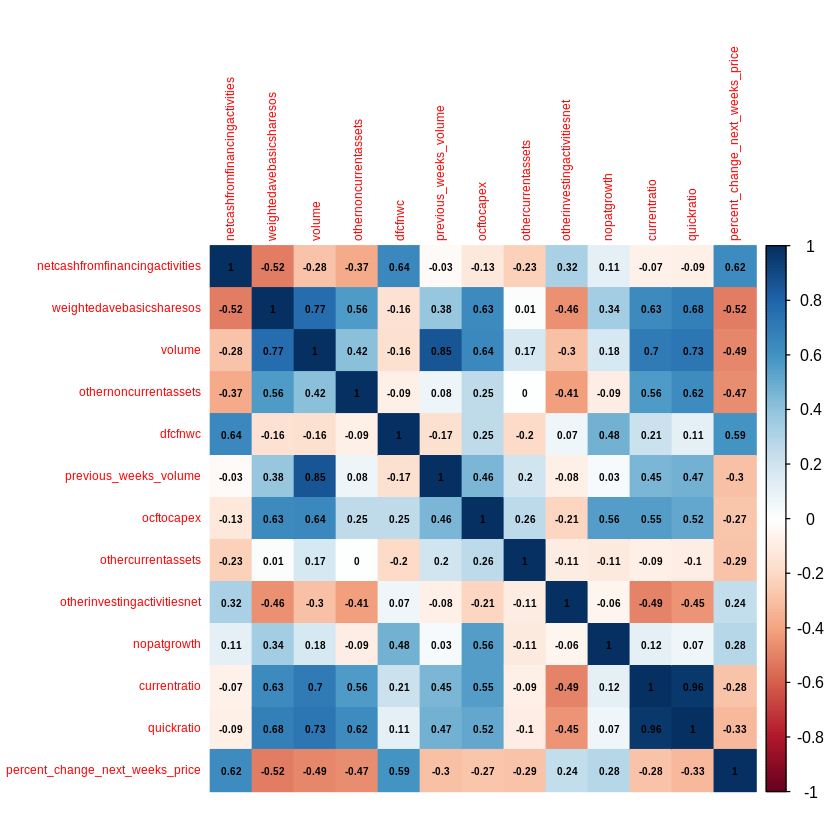

In [ ]:
# Select only the 10 variables we want to include in the heatmap
mostimportant <- complete[, c("netcashfromfinancingactivities",
                              "weightedavebasicsharesos",
                              "volume",
                              "othernoncurrentassets",
                              "dfcfnwc",
                              "previous_weeks_volume",
                              "ocftocapex",
                              "othercurrentassets",
                              "otherinvestingactivitiesnet",
                              "nopatgrowth",
                              "currentratio",
                              "quickratio",
                              "percent_change_next_weeks_price")]

# Compute the correlation matrix for the selected variables
correlation_matrix <- cor(mostimportant, use = "pairwise.complete.obs")

library(corrplot)

# Heatmap
corrplot(correlation_matrix,
         method = "color",
         addCoef.col = "black",
         tl.cex = 0.6,
         mar = c(0,0,0,0),
         number.cex = 0.5,
)


In [ ]:
install.packages("tree")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message in tree(percent_change_next_weeks_price ~ ., data = complete):
“NAs introduced by coercion”


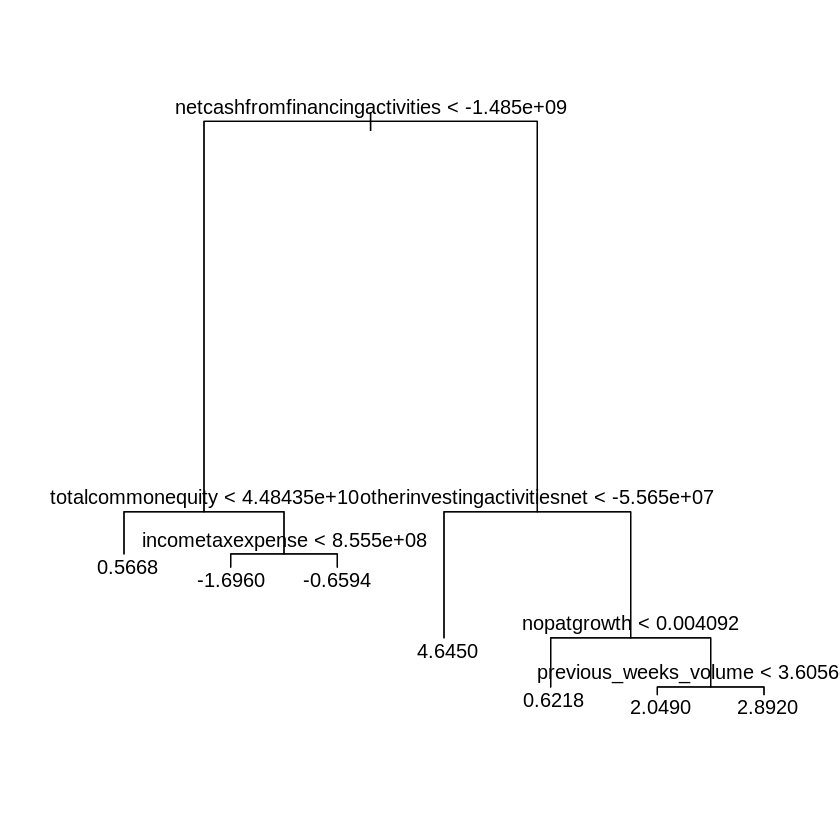

In [ ]:
library(tree)
reg.tree = tree(percent_change_next_weeks_price~.,data = complete)
plot(reg.tree)
text(reg.tree ,pretty = 5)

In [ ]:
# plot(complete$percent_change_next_weeks_price, complete$netcashfromfinancingactivities)

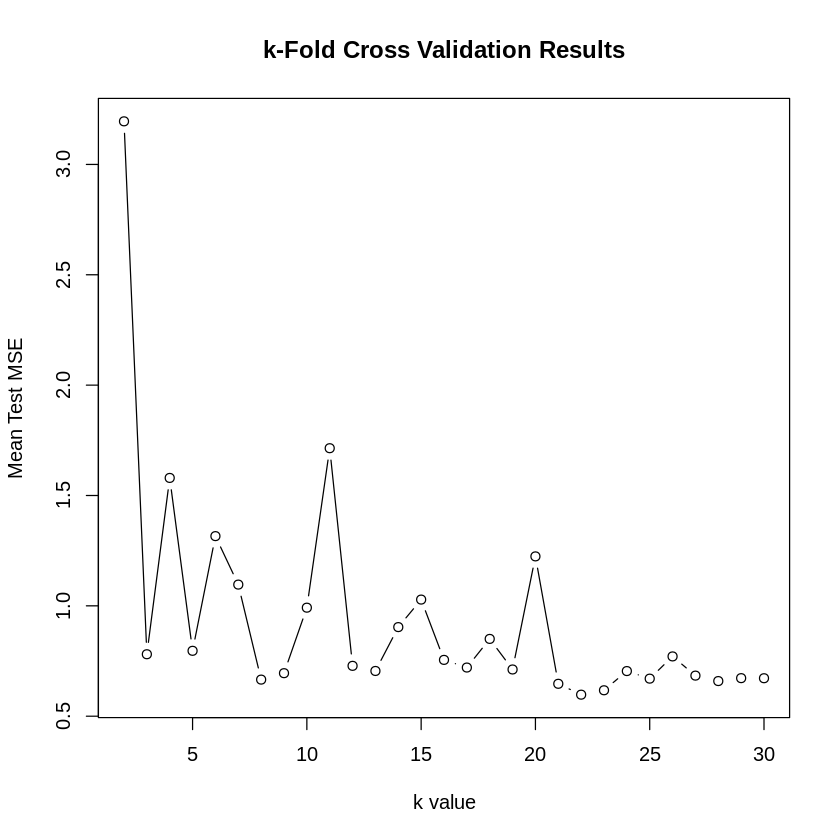

In [ ]:
# test a range of different folds

library(readr)
library(randomForest)

df <- complete

# Remove unnecessary columns
df$stock <- NULL
df$date <- NULL

set.seed(123) # Ensure reproducibility

# Define the custom createFolds function
createFolds <- function(data, k) {
  folds <- sample(rep(1:k, length.out = nrow(data)))
  return(folds)
}

# Placeholder for storing results
k_values <- 2:30
mean_mse_values <- numeric(length(k_values))

for (k in k_values) {
  fold_indices <- createFolds(df, k)
  mse_values <- numeric(k)

  for (j in 1:k) {
    test_indices <- which(fold_indices == j)
    train_indices <- setdiff(1:nrow(df), test_indices)

    trainSet <- df[train_indices, ]
    testSet <- df[test_indices, ]

    rf_model <- randomForest(percent_change_next_weeks_price ~ ., data=trainSet, ntree=500, importance=TRUE)
    predictions_rf <- predict(rf_model, newdata=testSet)

    mse_values[j] <- mean((predictions_rf - testSet$percent_change_next_weeks_price)^2)
  }

  mean_mse_values[k-1] <- mean(mse_values)
}

# Plotting the mean MSE values against different k values
plot(k_values, mean_mse_values, type='b', xlab="k value", ylab="Mean Test MSE", main="k-Fold Cross Validation Results")

In [ ]:
#random forest k= 13 folds

library(readr)
library(randomForest)

df <- complete

# Remove unnecessary columns
df$stock <- NULL
df$date <- NULL

set.seed(123) # Ensure reproducibility

# Define the custom createFolds function
createFolds <- function(data, k) {
  folds <- sample(rep(1:k, length.out = nrow(data)))
  return(folds)
}

# Placeholder for storing results
k_values <- 13
# mean_mse_values <- numeric(length(k_values))

for (k in k_values) {
  fold_indices <- createFolds(df, k)
  mse_values <- numeric(k)

  for (j in 1:k) {
    test_indices <- which(fold_indices == j)
    train_indices <- setdiff(1:nrow(df), test_indices)

    trainSet <- df[train_indices, ]
    testSet <- df[test_indices, ]

    rf_model <- randomForest(percent_change_next_weeks_price ~ ., data=trainSet, ntree=500, importance=TRUE)
    predictions_rf <- predict(rf_model, newdata=testSet)

    mse_values[j] <- mean((predictions_rf - testSet$percent_change_next_weeks_price)^2)
  }

  mean_mse_value <- mean(mse_values)
}



In [ ]:
print(mean_mse_value)


[1] 0.8910875


In [ ]:
# plot(complete$percent_change_next_weeks_price, complete$dfcfnwc)

In [ ]:
# plot(complete$percent_change_next_weeks_price, complete$totaloperatingexpenses)

In [ ]:
# plot(complete$percent_change_price, complete$totaloperatingexpenses)


Call:
lm(formula = percent_change_next_weeks_price ~ othernoncurrentassets + 
    dfcfnwc + ocftocapex + nopatgrowth, data = complete)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9767 -0.3688  0.0659  0.3971  3.7740 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.743e+00  3.518e-01   7.795 1.78e-09 ***
othernoncurrentassets -3.011e-11  1.103e-11  -2.730 0.009455 ** 
dfcfnwc                2.466e-10  4.567e-11   5.399 3.53e-06 ***
ocftocapex            -3.486e-01  8.607e-02  -4.051 0.000235 ***
nopatgrowth            1.864e-02  9.376e-03   1.988 0.053828 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.294 on 39 degrees of freedom
Multiple R-squared:  0.6662,	Adjusted R-squared:  0.632 
F-statistic: 19.46 on 4 and 39 DF,  p-value: 7.132e-09


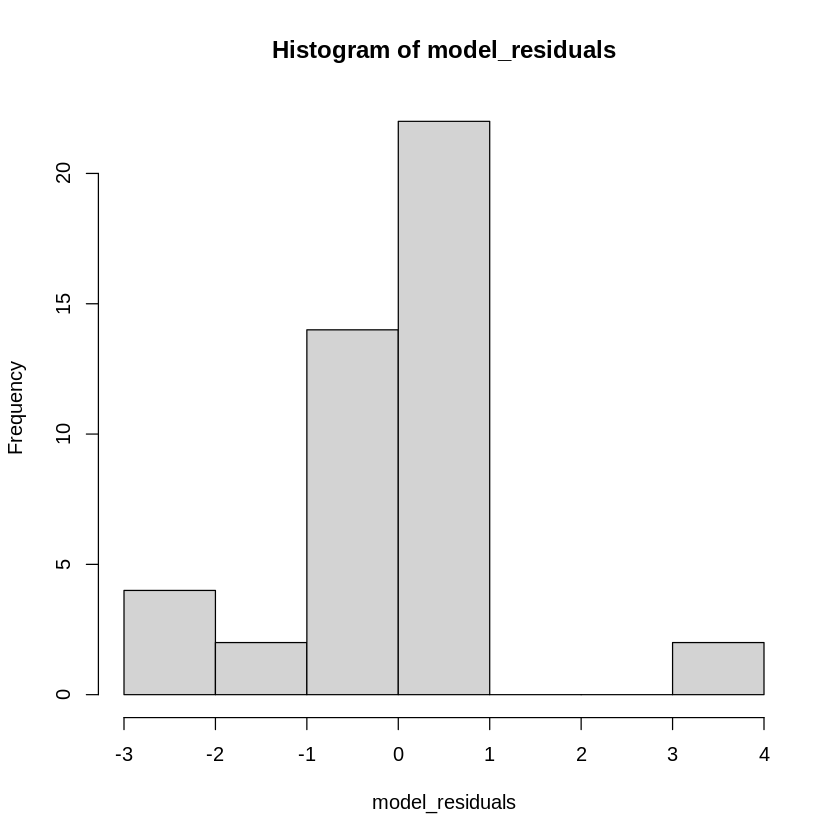

In [ ]:
lm_model <- lm(percent_change_next_weeks_price ~ othernoncurrentassets + dfcfnwc + ocftocapex + nopatgrowth, data = complete)
summary(lm_model)

#Plot residuals from the linear model
model_residuals = lm_model$residuals
hist(model_residuals)
#We can see it is generally normal.

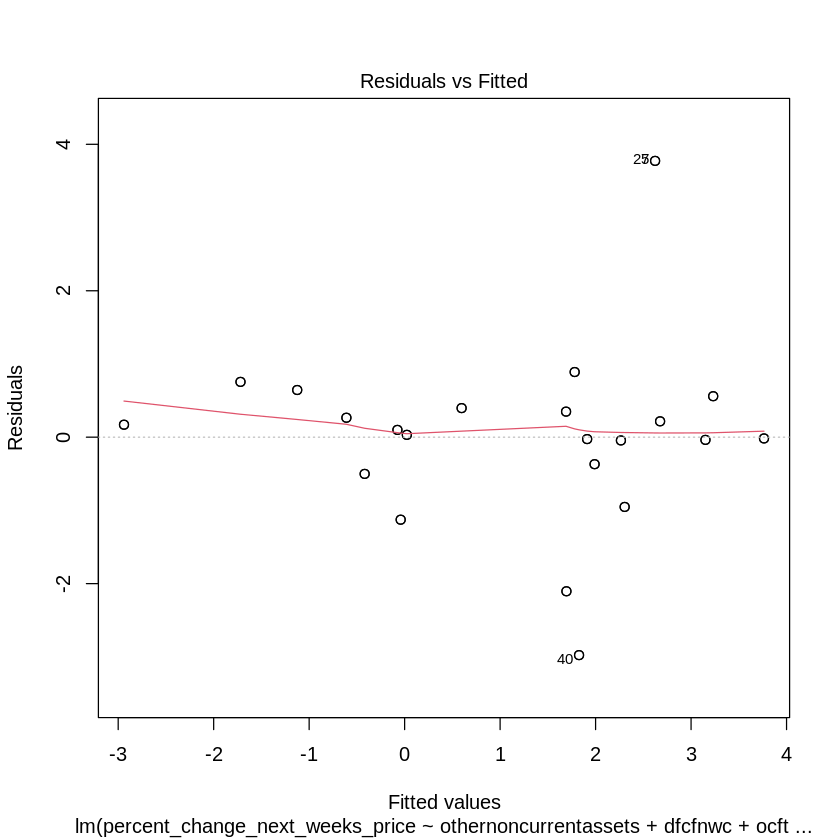

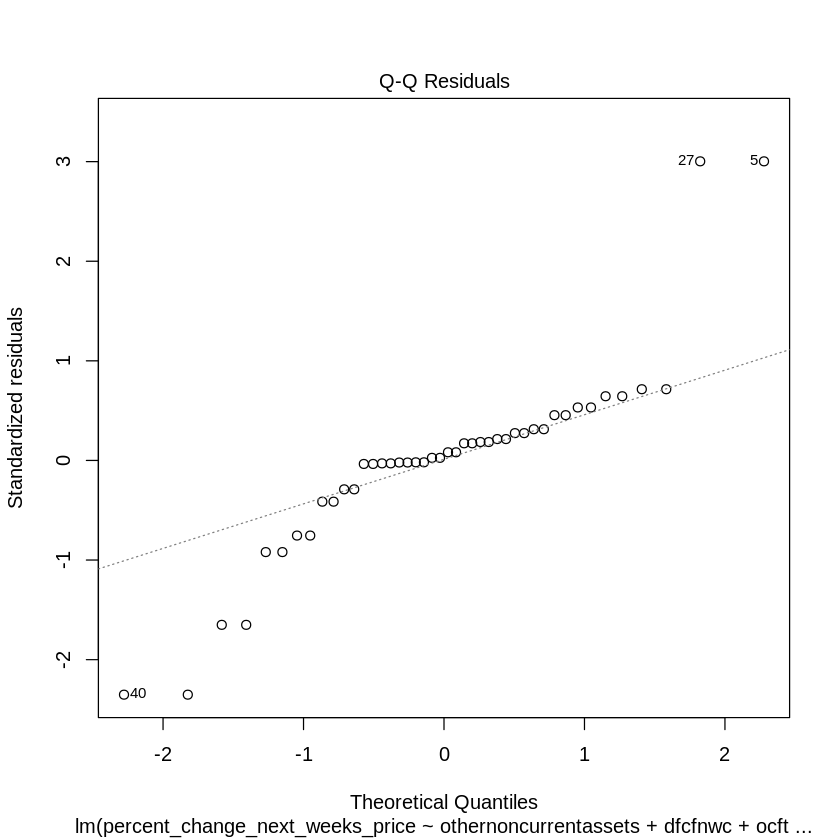

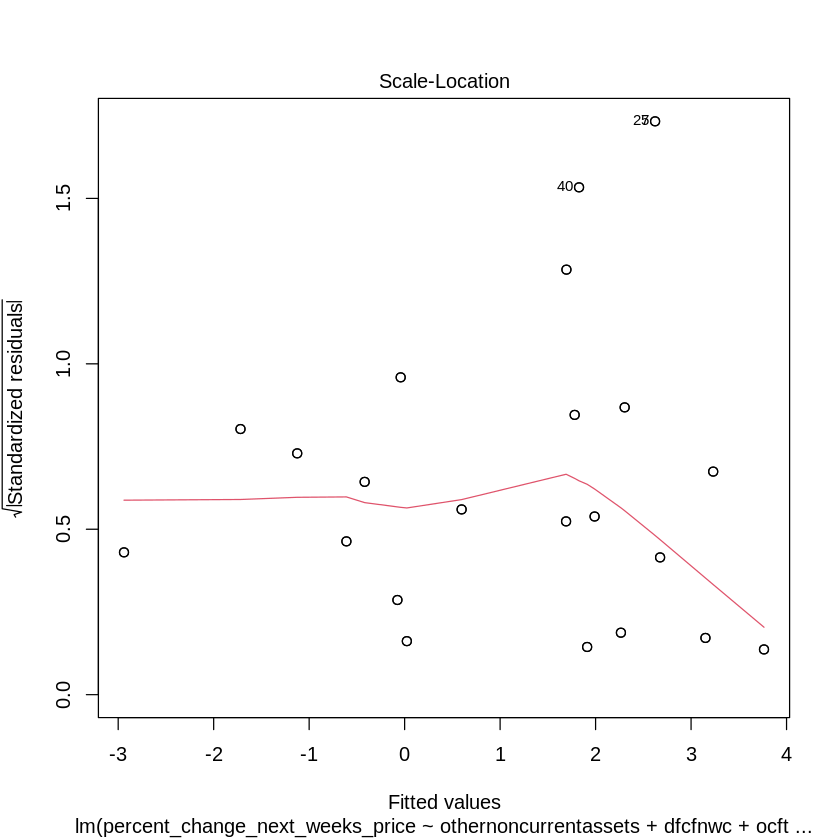

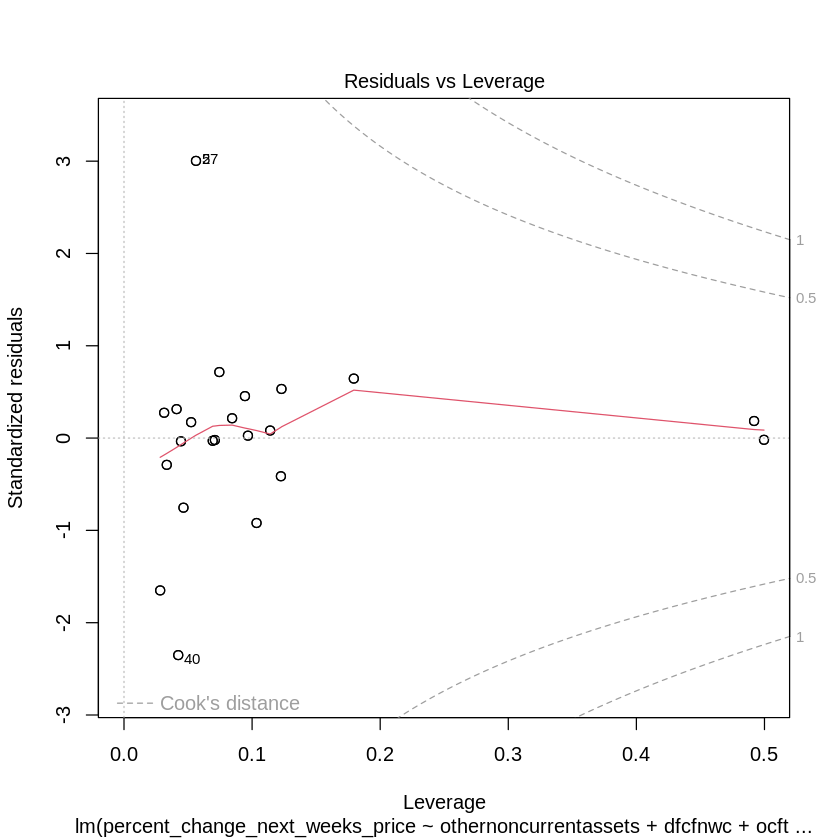

In [ ]:
# Plot the residuals
plot(lm_model)


##### we will not eliminate the outliers in our data set because we are analyzing a stock index and the behavior is simply a natural part of the data we are analyzing
##### might be beneficial to examine the outliers outside the context of this project in the case of outsized returns




In [ ]:
quadratic_model <- lm(percent_change_next_weeks_price ~
                              poly(dfcfnwc,1)+
                              poly(ocftocapex,1)+
                              poly(nopatgrowth,1)+
                              I(currentratio^2)+
                              poly(quickratio,1), data = complete)

summary(quadratic_model)


Call:
lm(formula = percent_change_next_weeks_price ~ poly(dfcfnwc, 
    1) + poly(ocftocapex, 1) + poly(nopatgrowth, 1) + I(currentratio^2) + 
    poly(quickratio, 1), data = complete)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9327 -0.5922 -0.1813  0.8098  3.4019 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.8565     0.5519   5.176 7.66e-06 ***
poly(dfcfnwc, 1)       8.5810     1.4144   6.067 4.61e-07 ***
poly(ocftocapex, 1)   -7.0389     1.8217  -3.864 0.000422 ***
poly(nopatgrowth, 1)   3.7629     1.7301   2.175 0.035924 *  
I(currentratio^2)     -0.5062     0.1514  -3.344 0.001866 ** 
poly(quickratio, 1)   10.7700     4.1804   2.576 0.013996 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.23 on 38 degrees of freedom
Multiple R-squared:  0.7058,	Adjusted R-squared:  0.6671 
F-statistic: 18.24 on 5 and 38 DF,  p-value: 3.355e-09


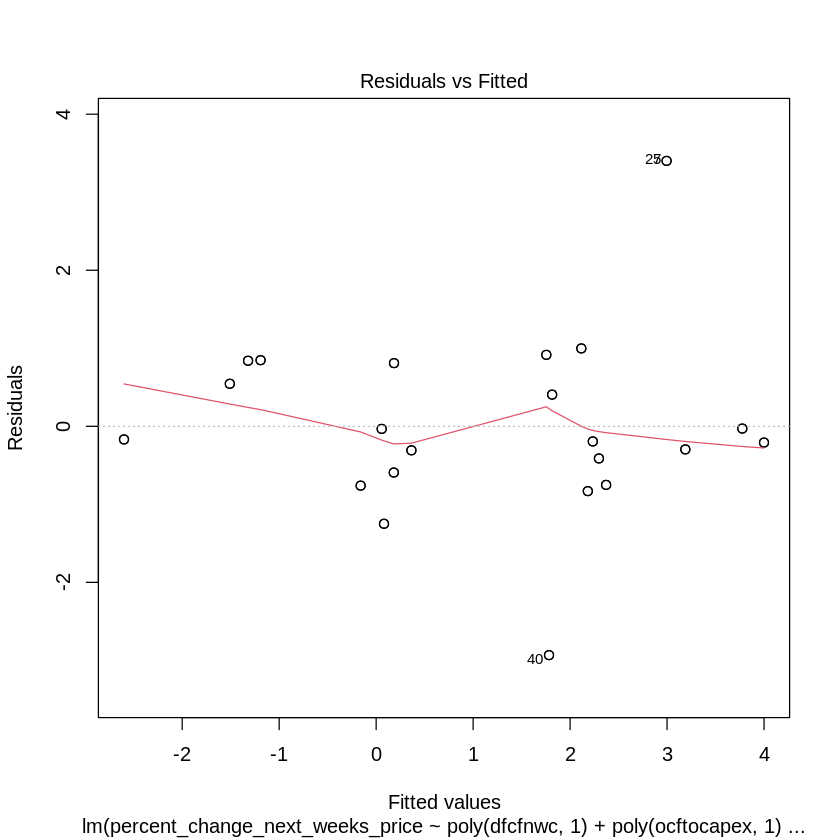

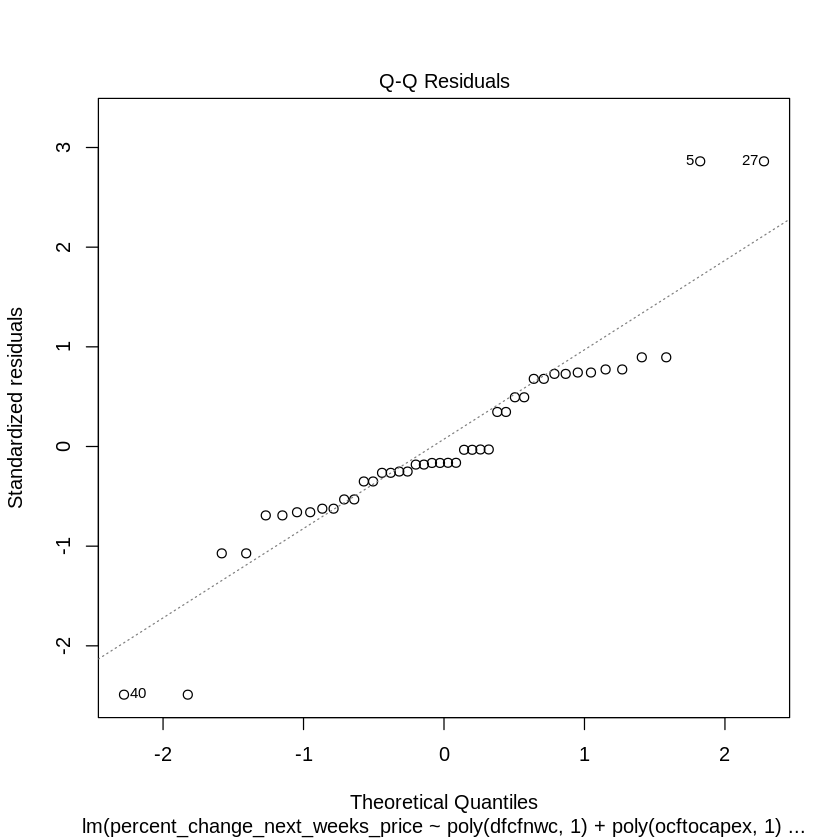

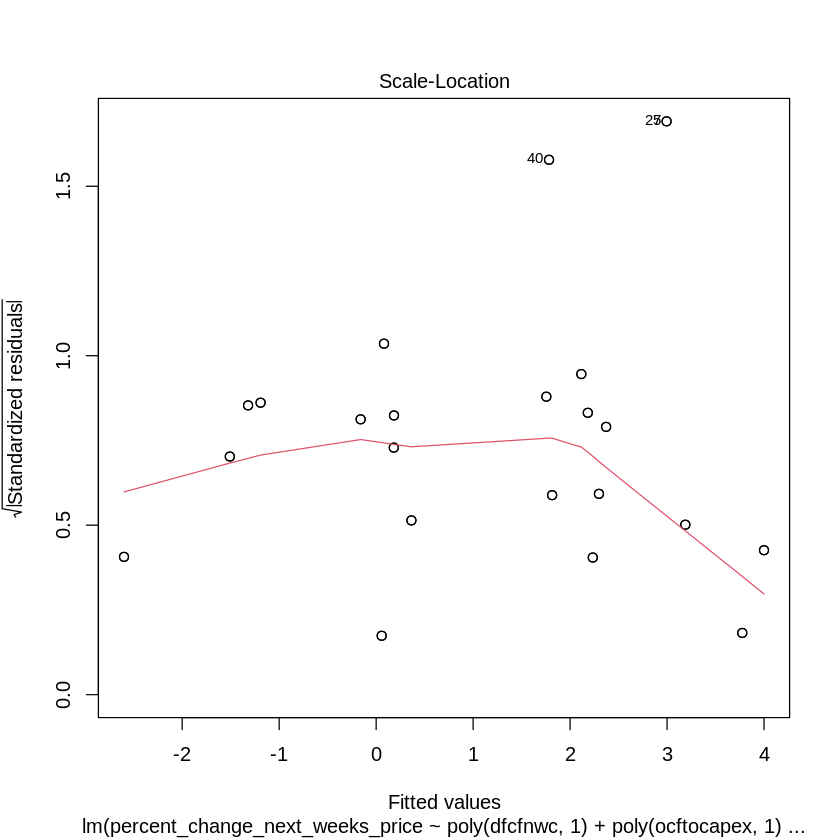

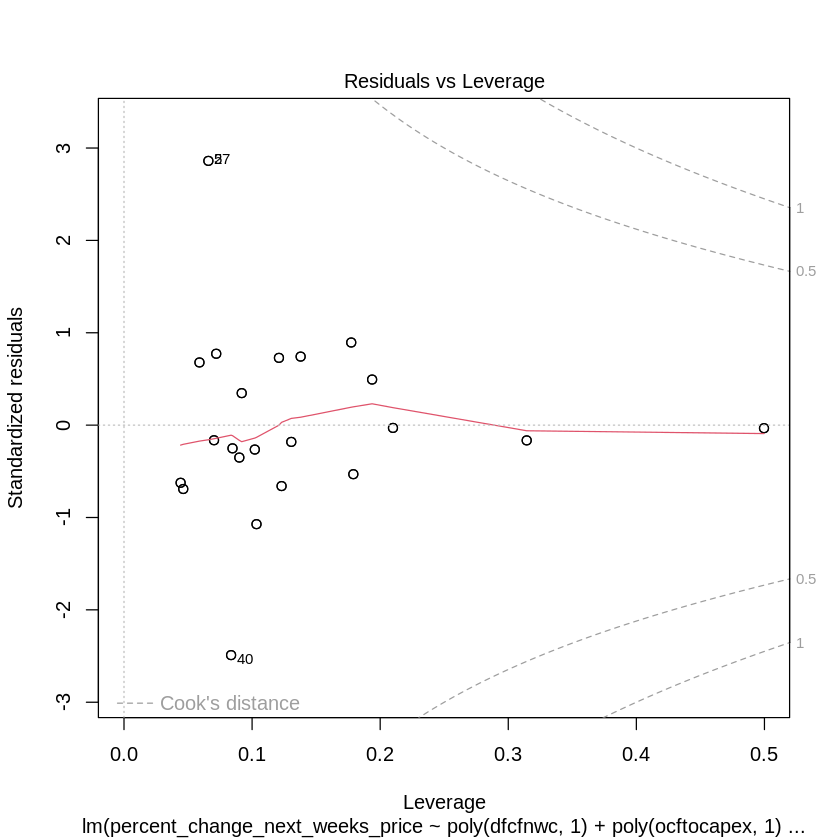

In [ ]:
plot(quadratic_model)

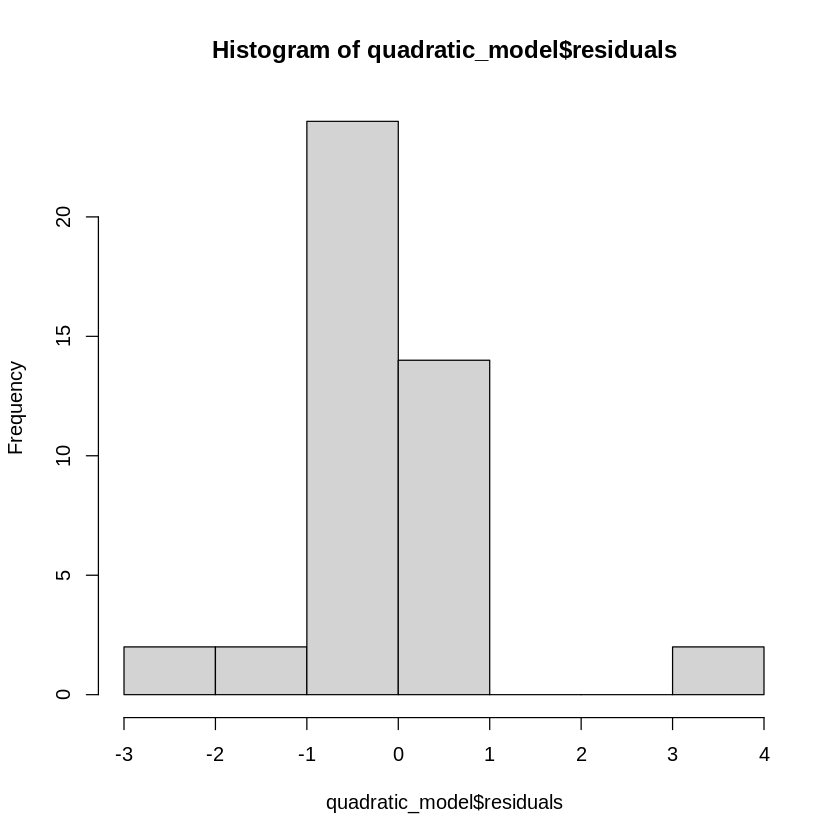

In [ ]:
hist(quadratic_model$residuals)

In [ ]:
# plot(complete$percent_change_next_weeks_price)

In [ ]:
createFolds <- function(data, k) {
  folds <- sample(rep(1:k, length.out = nrow(data)))
  return(folds)
}


In [ ]:
# gather MSE for k folds 2 to 44 (total number of rows) linear model
MSE_k <- numeric(44)
set.seed(123) # For reproducibility

for(j in 2:44){
  #print(j)
  k <- j
  folds <- createFolds(complete, k)
  mse_list <- numeric(k)  # To store mean squared errors for each fold
  for(i in 1:k) {
    # Splitting the data into training and validation sets
    trainData <- complete[folds != i, ]
    testData <- complete[folds == i, ]

    # Fit the model to the training data
    model <- lm(percent_change_next_weeks_price ~ othernoncurrentassets + dfcfnwc + ocftocapex + nopatgrowth, data = trainData)

    # Predicting and calculating Mean Squared Error (MSE)
    predictions <- predict(model, testData)
    # print(predictions)
    mse_list[i] <- mean((testData$percent_change_next_weeks_price - predictions)^2)
    # print(mse_list)
  }

  # Calculate the average MSE across all folds
  avg_mse <- mean(mse_list)

  #print(mse_list)
  #print(avg_mse)
  # print(paste("Average MSE across all folds:", avg_mse))
  MSE_k[j] <- avg_mse

}


In [ ]:
MSE_k

[1]  0.000000  3.994888  1.683917  1.865441  1.638748 17.119479  1.729723
 [8]  1.586468  1.702948  1.744527 27.504871  1.824728  1.786291  1.741449
[15]  1.675193  1.643784  1.606211  1.579740  1.629575 28.008576  1.721834
[22]  1.662741  1.598355  1.863575 23.065063  1.762290  1.903682  1.429399
[29]  1.764026  1.737197  1.560214  1.420817  1.256691  1.538596  1.628025
[36]  1.799669  1.374802  1.706234  1.831217  1.544937  1.558891  1.742008
[43]  1.690109  1.666129

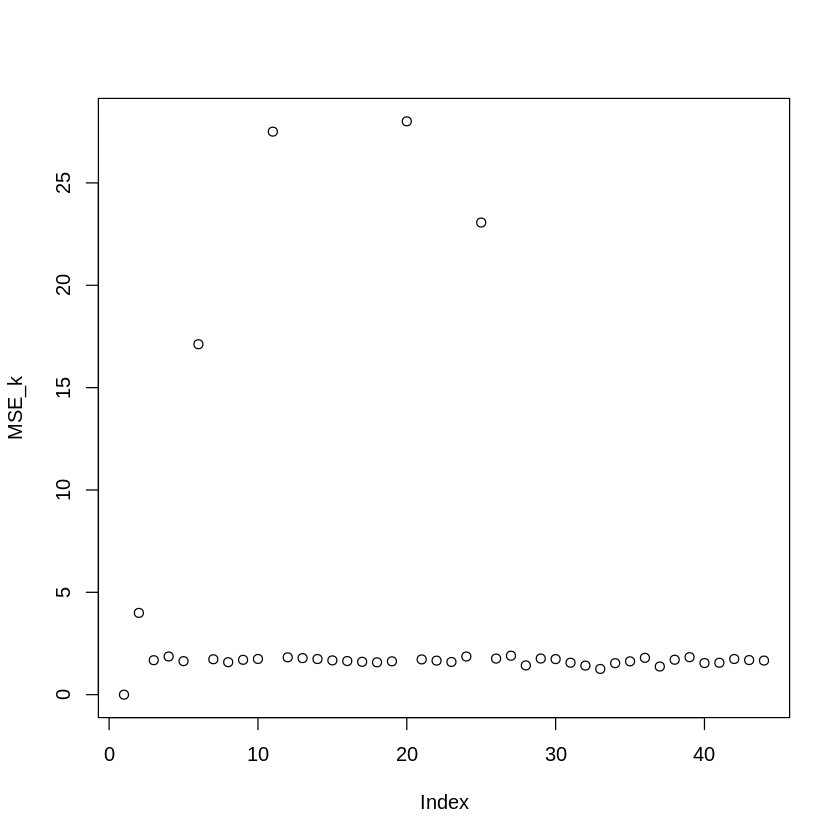

In [ ]:
plot(MSE_k)

In [ ]:
# gather MSE for k folds 2 to 44 (total number of rows) quadratic model
MSE_k <- numeric(44)
set.seed(123) # For reproducibility

for(j in 2:44){
  #print(j)
  k <- j
  folds <- createFolds(complete, k)
  mse_list <- numeric(k)  # To store mean squared errors for each fold
  for(i in 1:k) {
    # Splitting the data into training and validation sets
    trainData <- complete[folds != i, ]
    testData <- complete[folds == i, ]

    # Fit the model to the training data
    model <- lm(percent_change_next_weeks_price ~
                                                  poly(dfcfnwc,1)+
                                                  poly(ocftocapex,1)+
                                                  poly(nopatgrowth,1)+
                                                  I(currentratio^2)+
                                                  poly(quickratio,1), data = trainData)

    # Predicting and calculating Mean Squared Error (MSE)
    predictions <- predict(model, testData)
    # print(predictions)
    mse_list[i] <- mean((testData$percent_change_next_weeks_price - predictions)^2)
    # print(mse_list)
  }

  # Calculate the average MSE across all folds
  avg_mse <- mean(mse_list)

  #print(mse_list)
  #print(avg_mse)
  # print(paste("Average MSE across all folds:", avg_mse))
  MSE_k[j] <- avg_mse

}


In [ ]:
print(MSE_k)


 [1]  0.000000  2.356352  1.444291  1.903553  1.513731 54.500585  1.582810
 [8]  1.640801  1.567561  1.661156 80.036586  1.742350  1.653162  1.609315
[15]  1.566870  1.580770  1.527607  1.596672  1.523519 87.758102  1.614976
[22]  1.574708  1.504926  1.753415 70.746019  1.652553  1.805565  1.385543
[29]  1.697663  1.679793  1.434685  1.230747  1.198849  1.520109  1.530069
[36]  1.675565  1.266900  1.590216  1.712753  1.506978  1.490153  1.629571
[43]  1.588263  1.564125


In [ ]:
# mean(MSE_k)

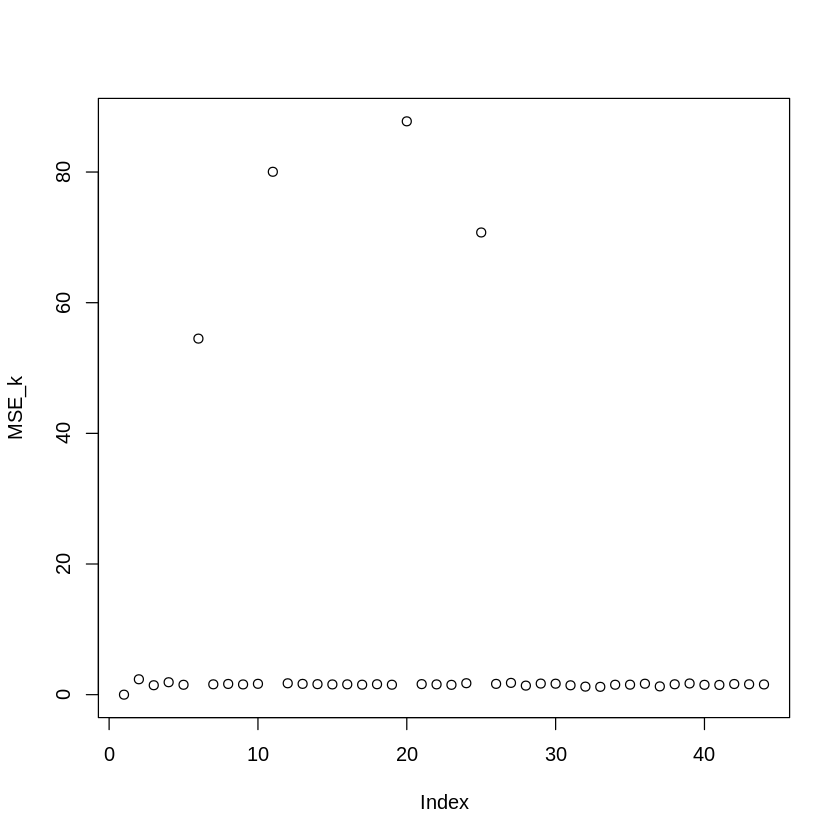

In [ ]:
plot(MSE_k)

In [ ]:
print(MSE_k)

 [1]  0.000000  2.356352  1.444291  1.903553  1.513731 54.500585  1.582810
 [8]  1.640801  1.567561  1.661156 80.036586  1.742350  1.653162  1.609315
[15]  1.566870  1.580770  1.527607  1.596672  1.523519 87.758102  1.614976
[22]  1.574708  1.504926  1.753415 70.746019  1.652553  1.805565  1.385543
[29]  1.697663  1.679793  1.434685  1.230747  1.198849  1.520109  1.530069
[36]  1.675565  1.266900  1.590216  1.712753  1.506978  1.490153  1.629571
[43]  1.588263  1.564125


In [ ]:
# library(glmnet)

# # Data preparation
# x_next_week_price <- model.matrix(percent_change_next_weeks_price ~ . -1, data = complete)
# y_next_week_price <- complete$percent_change_next_weeks_price

# # Lasso regression for percent_change_next_weeks_price
# set.seed(123)
# cv_next_week_price <- cv.glmnet(x_next_week_price, y_next_week_price, alpha = 1)
# plot(cv_next_week_price)
# bestLambda_next_week_price <- cv_next_week_price$lambda.min
# lassoModel_next_week_price <- glmnet(x_next_week_price, y_next_week_price, alpha = 1, lambda = bestLambda_next_week_price)



In [ ]:
# library(caret)

# # Assuming 'complete' is your dataframe and is already loaded

# # Define control using repeated cross-validation
# control <- rfeControl(functions=rfFuncs, method="cv", number=10, verbose=FALSE)

# # For percent_change_next_weeks_price
# set.seed(123)
# rfeModel_next_week_price <- rfe(complete[, setdiff(names(complete), "percent_change_next_weeks_price")],
#                                 complete$percent_change_next_weeks_price,
#                                 sizes=c(1:10),
#                                 rfeControl=control)
# print(rfeModel_next_week_price)

